In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import networkx as nx

from src.Dataset import HiC_Dataset
from src.layers.WEGATConv import WEGATConv

import torch
from torch import Tensor
import torch.nn.functional as F
from torch.nn import Parameter, Linear
import torch_geometric as tgm
from torch_geometric.nn import global_mean_pool

In [11]:
bigwigs = os.listdir("Data/raw/bigwigs")
contacts = os.listdir("Data/raw/contacts")
target = "target.tsv"

In [12]:
train_dset = HiC_Dataset("Data",
                   contacts=contacts,
                   bigwigs=bigwigs,
                   target=target)

In [13]:
fnames = ['Mbd3',
          'WT_CTCF',
          'KO_CTCF',
          'WT_Smc3',
          'KO_Smc3',
          '0h_H3K27ac',
          '1h_H3K27ac',
          '24h_H3K27ac',
          '48h_H3K27ac',
          'WT_Nanog',
          'KO_Nanog',
          'WT_Klf4',
          'KO_Klf4',
          '0h_H3K4me3',
          '24h_H3K4me3',
          'KO_Chd4',
          '24h_Chd4',
          '48h_Chd4']

In [14]:
def torch_to_nx(arch, fnames= fnames):
    G = nx.Graph()
    G.add_nodes_from([(idx, 
                     {fnames[jdx]: arch.x.numpy()[idx,jdx] for jdx in np.arange(len(fnames))
                     }
                     ) for idx in np.arange(arch.x.numpy().shape[0])
                     ]
                   )
    G.add_edges_from([(arch.edge_index.numpy()[0,idx],
                       arch.edge_index.numpy()[1,idx],
                     {'WT_weight': arch.edge_attr.numpy()[idx,0],
                      'KO_weight': arch.edge_attr.numpy()[idx,1],
                      'backbone': arch.edge_attr.numpy()[idx,2],
                      }
                     ) for idx in np.arange(arch.edge_index.numpy().shape[1])
                     ])
    
    return G, arch.name

In [15]:
def symlog(vec):
    out = vec.copy()
    out[vec>1]=1+np.log(out[vec>1])

    return out

def draw_graph(G,
               ax, 
               weight = 'WT_weight',
               color_nodes_by = 'Mbd3',
               node_cmap = 'Blues',
               edge_cmap = 'Reds',
               log_node_color = True,
               log_edge_weight = True
               ):
  
    pos = nx.spring_layout(G, weight = weight)

    nx.draw_networkx_nodes(G,
                           pos,
                           nodelist = [25],
                           node_size = 500,
                           node_color = 'red',
                           ax = ax
                           )

    node_cols = np.array([G.nodes[node][color_nodes_by] for node in G.nodes()])
    if log_node_color:
        node_cols = symlog(node_cols)

    nx.draw_networkx_nodes(G, 
                           pos, 
                           node_color=node_cols,
                           cmap = node_cmap,
                           node_size = 150,
                           ax = ax
                           )
    
    edge_weights = np.array([G[edge[0]][edge[1]][weight] for edge in G.edges()])
    if log_edge_weight:
        edge_weights = symlog(edge_weights)

    nx.draw_networkx_edges(G,
                           pos,
                           edge_color = edge_weights,
                           edge_cmap = plt.cm.Greys,
                           connectionstyle = 'arc3,rad=0.2',
                           ax = ax 
                           )
    
    nx.draw_networkx_edges(G,
                           pos,
                           edgelist = [edge for edge in G.edges() if G[edge[0]][edge[1]]['backbone']==True],
                           edge_color = 'red',
                           width = 2,
                           connectionstyle = 'arc3,rad=0.2',
                           ax = ax 
                           )
    
    
    


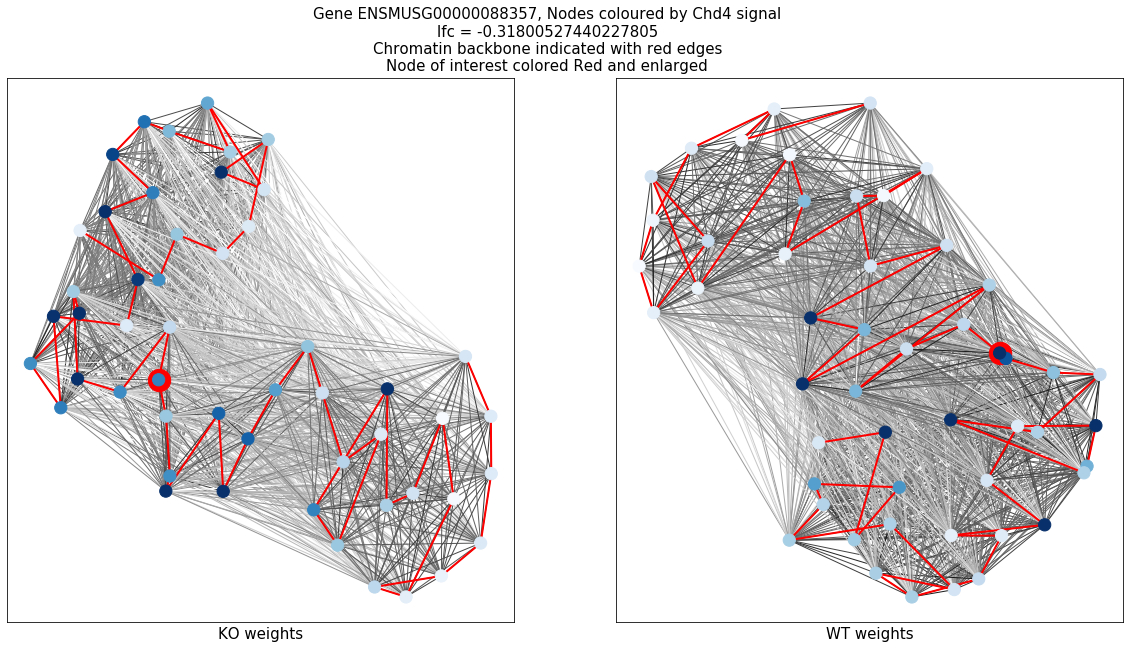

In [16]:
fig,ax = plt.subplots(1,2, figsize = (20,10))
node_col_WT = '48h_Chd4'
node_col_KO = 'KO_Chd4'
idx = 5
dat,name = torch_to_nx(train_dset[idx])
draw_graph(dat,
           ax[1],
           color_nodes_by=node_col_WT)
ax[1].set_xlabel("WT weights", size = 15)

draw_graph(dat,
           ax[0],
           color_nodes_by=node_col_KO, 
           weight = 'KO_weight')
ax[0].set_xlabel("KO weights", size = 15)

title = fig.suptitle(f"Gene {name}, Nodes coloured by Chd4 signal\nlfc = {train_dset[idx].y}\nChromatin backbone indicated with red edges\nNode of interest colored Red and enlarged",
         size = 15)

# Building a net

In [17]:
NUMCHIP = train_dset.num_node_features
NUMEDGE = train_dset.num_edge_features

class WEGAT_Net(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(WEGAT_Net, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = WEGATConv(in_channels = NUMCHIP, 
                            node_out_channels = hidden_channels, 
                            edge_channels = NUMEDGE,
                            edge_out_channels = NUMEDGE
                           )
        self.conv2 = WEGATConv(in_channels = hidden_channels, 
                            node_out_channels = hidden_channels, 
                            edge_channels = NUMEDGE,
                            edge_out_channels = NUMEDGE
                           )
        self.conv3 = WEGATConv(in_channels = hidden_channels, 
                            node_out_channels = hidden_channels, 
                            edge_channels = NUMEDGE,
                            edge_out_channels = NUMEDGE
                           )
        self.lin = Linear(hidden_channels, 1)

    def forward(self, x, edge_index, edge_attr, batch):
        # 1. Obtain node embeddings 
        x, edge_attr = self.conv1(x.float(), edge_attr.float(), edge_index)
        x = x.relu()
        edge_attr.relu()
        x, edge_attr = self.conv2(x, edge_attr,edge_index)
        x = x.relu()
        edge_attr.relu()
        x,_ = self.conv3(x, edge_attr,edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = self.lin(x)
        
        return x

In [18]:
model = WEGAT_Net(hidden_channels=30)
dat = train_dset[10]
model(dat.x, 
      dat.edge_index, 
      dat.edge_attr, 
      torch.full((51,),0))

tensor([[-0.0838]], grad_fn=<AddmmBackward>)

In [19]:
from torch_geometric.data import DataLoader
train_loader = DataLoader(train_dset, batch_size=3)

In [20]:
for data in train_loader:
    print(model(data.x, data.edge_index, data.edge_attr, data.batch))
    break

tensor([[-0.1200],
        [-0.1140],
        [-0.0870]], grad_fn=<AddmmBackward>)
